In [1]:
import os
import numpy as np
import re
import pickle
import pandas as pd
from datetime import datetime
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
import nltk
from bs4 import BeautifulSoup
from contractions import contractions_dict
import unicodedata
import keras
from collections import Counter
import tensorflow as tf
from sklearn.metrics import classification_report, roc_curve, auc
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Concatenate, Dense, Dropout, LSTM, Embedding, CuDNNLSTM, Input,  Flatten
from keras.optimizers import Adamax, Adam
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
field_names = ['id', 'type', 'is_best_answer', 'topic_id', 'parent_id', 'votes',
               'title', 'content', 'member', 'category', 'state', 'is_solved', 'num_answers',
               'country', 'date', 'last_answer_date', 'author_crc', 'visits']

txt_path ="QA/export-forums_en.csv"
entity_path ="QA/export-forums_en.pickle"
csv_path = "QA/export-forums_en.format.csv"
data_path = "QA/"
extracted="QA/cleaned.csv"
train_final="QA/train_final.pickle"
test_final="QA/test_final.pickle"

In [3]:

def format_entities():
    '''
    Read the raw data, format the list of entities, serialize them.
    '''

    def build_entities(txt_path, max_entities=None):
        '''
        Return a list of structured entities from raw txt file.
        '''
        # Read text file.
        with open(txt_path, 'r', encoding='utf8') as f:
            # Entities and current entity.
            entities, entity = [], {}
            # Entity values might be split over lines
            field_counter = 0
            # Process lines
            for line in f:
                # Prepare line
                line = line.replace("\\N", '"unkwown"')
                # Char start for extracted value.
                char_start = 1
                # Find values separators
                field_index = [m.start() for m in re.finditer('","', line)]
                # Browse value separators.
                for index in field_index:
                    # Extract in between value.
                    value = line[char_start:index]
                    # Update start index.
                    char_start = index + 3
                    # Update field counter.
                    field_counter += 1
                    # Update entity value.
                    try:
                        entity[field_names[field_counter-1]] += value
                    except KeyError:
                        entity[field_names[field_counter-1]] = value
                    except IndexError:
                        entity = {}
                        field_counter = 0
                # Content string is split.
                if field_counter == 7 and len(field_index) > 0:
                    entity[field_names[7]] = line[field_index[-1]:]
                    continue
                # Next content string.
                if field_counter == 7 and len(field_index) == 0:
                    entity[field_names[7]] += line
                    continue
                # Next entity.
                if len(entity) == 17:
                    field_counter = 0
                    entities.append(entity)
                    entity = {}
                    if max_entities is not None:
                        if len(entities) > max_entities:
                            return entities
        return entities
    print()
    # Write entities on disk.
    with open(entity_path,'wb') as f:
        pickle.dump(build_entities(txt_path=txt_path, max_entities=None), f)


In [4]:
def entities_to_csv():
    '''
    Format entities to csv.
    '''
    with open(entity_path, 'rb') as obj:
        entities = pickle.load(obj)
    x = pd.DataFrame(entities)
    x.to_csv(csv_path)


In [9]:
if __name__ == '__main__':
    format_entities()
    entities_to_csv()


Entities:  715516
Users:  230923
Questions:  264962
Answers:  328280
Comments:  122274
uq:  264962
ua:  328280
qa:  328280
uc:  106063
ca:  106063


# Use Random forest to caculate and choose other useful features

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
df=pd.read_csv(csv_path)
# from sklearn.feature_selection import SelectFromModel
feat_labels=df.drop(["is_best_answer","title","content","country","type","Unnamed: 0"],axis=1).columns.values.tolist()
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0)

In [5]:
# Train the classifier
X=df.loc[df["type"]=="A"].drop(["is_best_answer","title","content","country","type","Unnamed: 0"],axis=1)
y=df.loc[df["type"]=="A"]["is_best_answer"]
clf.fit(X,y)
# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)
# will use "votes" "num_answers" "state" and "country"

('id', 0.03291418718893231)
('topic_id', 0.03543378831644127)
('parent_id', 0.03454129532787189)
('votes', 0.6157130959889361)
('member', 0.026861053362471105)
('category', 0.016593547306053898)
('state', 0.04179451660779571)
('is_solved', 0.02119736843792024)
('num_answers', 0.08632357978728289)
('date', 0.03174375374894221)
('last_answer_date', 0.033322473870419915)
('author_crc', 0.02356134005693237)


# Extract useful data and apply Data cleaning
Extract useful columns and merge comments, also generate 2 new columns: comments number belongs to certain answer, and standarlized date of an answer(standarlize by sequence of the answer)  
Clean Data.   
include Beautifulsoup(delete html tags),  
remove accented chars, 
expand contractions,  
delete puntuations and numbers and lowerecase,  
delete redundant whitespace,  
delete stopwords,   
stemmer words  

In [9]:
def extract_data():
    #extract useful columns by answers, merge all the comments belong to certain answer
    entities=pd.read_csv(csv_path)
    entities['content'] = entities['content'].apply(lambda x: str(x)+" ")
    df=[]
    for index, line in entities.iterrows():
        if line["type"]=="A":
            #extract 'answer_id',"title","question",'answer',"comments",'votes','num_answers',"state","country" and "best answer"information
            answer_id=line['id']
            title=line['title']
            question=entities[entities["id"]==line['parent_id']]["content"].sum()
            answer=line['content']
            comments=entities[entities["parent_id"] == line["id"] ]["content"].sum()
            votes=line['votes']
            num_answers=line["num_answers"]
            state=line["state"]
            country=line["country"]
            is_best_answer=line["is_best_answer"]
            
            #Calculate comment number of an answer
            comment_number=len(entities[entities["parent_id"] ==  line["id"]])
            
            #Caculate answer time (standarlized)
            lists=entities.loc[entities["parent_id"] ==  line["parent_id"]]
            max_tmp = np.max(np.array(lists["date"]))
            min_tmp = np.min(np.array(lists["date"]))
            if (max_tmp != min_tmp):
                lists["date"] = lists["date"].apply(lambda x: (x - min_tmp) / (max_tmp - min_tmp))
                answer_time=lists[lists["id"] == line["id"] ].iloc[0,15]
            else:
                answer_time=0.5
                
            df.append([answer_id, title, question, answer, comments, votes, num_answers, state, country, comment_number, answer_time, is_best_answer])
    df=pd.DataFrame(df,columns=['answer_id',"title","question",'answer',"comments",'votes','num_answers',"state","country", "comment_number", "answer_time","is_best_answer"])
    df.to_csv(extracted,index=False)

In [11]:
def clean_data():
    pd.options.mode.chained_assignment = None  # default='warn'
    stemmer = SnowballStemmer("english")
    stop = nltk.corpus.stopwords.words('english')
    stop.remove('no')
    stop.remove('not')
    stop.remove('but')
    stop.append("br")
    stop.append("n")
    toktok = nltk.tokenize.toktok.ToktokTokenizer()
    def expand_contractions(text, contraction_mapping=contractions_dict):
    
        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())  
            if expanded_contraction is None:
                expanded_contraction=""
            else:
                expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction

        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text
    def remove_accented_chars(text):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text
    
    
    df=pd.read_csv(extracted)
    df[["title", "question", "answer", "comments"]]=df[["title", "question", "answer", "comments"]].astype(str)
    for col_name in ["title", "question", "answer", "comments"]:
        #delete html text/format
        df[col_name] = df[col_name].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
        
        #remove accented characters eg. "Sómě Áccěntěd těxt" to "Some Accented text"
        df[col_name] = df[col_name].apply(lambda x: remove_accented_chars(x))
        
        # expand contracted words eg. "we'll" to "we all", "you're" to "you are"
        df[col_name] = df[col_name].apply(lambda x: expand_contractions(str(x)))
        
        # delete puntuations
        df[col_name].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~’”“′‘\\\]',' ',inplace=True,regex=True)
        
        #delete numbers and certain formats and lowercase
        df[col_name] = df[col_name].apply(lambda x: re.sub(r'[^a-zA-z\s]', ' ', x).lower())
        
        #delete redundant whitespace
        df[col_name] = df[col_name].apply(lambda x: re.sub(' +', ' ', x))
        
        #tokenizer
        df[col_name] = df[col_name].apply(toktok.tokenize)
        
        # stemmer words and remove stop words
        df[col_name] = df[col_name].apply(lambda x: [stemmer.stem(word) for word in x if word not in stop])
        
        #add whitespace between words
        df[col_name] = df[col_name].apply(lambda x: " ".join(x))
        
    #combine question and title content together as question
    df["question"]=df["title"]+" "+df["question"]
    df.drop(["title"],axis=1,inplace=True)

    df.to_csv(extracted,index=False)


In [12]:
if __name__ == '__main__':
    extract_data()
    clean_data()

/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:294: UserWarning: "b'/usr'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "http://xbadv.konqi.fr/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarning: "http://www.howto-convert.net" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:357: UserWarni

In [36]:
df=pd.read_csv(extracted)
df

,answer_id,question,answer,comments,votes,num_answers,state,country,comment_number,answer_time,is_best_answer
0,13,window vista xp downgrad reformat hello bought...,not think lie one downgrad would mean take awa...,stupidest post world go delet os use network f...,0,180,1,FR,9,0.000000,0
1,47,window vista xp downgrad reformat hello bought...,well alway downgrad window vista xp but everyt...,hp laptop dv tu vista but want xp load but dri...,-1,180,1,unkwown,3,0.006382,0
2,3062,window vista xp downgrad reformat hello bought...,j ust done thing hp dv operatingsystem got dri...,put two os one laptop mayb way email id remov ...,-1,180,1,unkwown,1,0.079603,0
3,3701,window vista xp downgrad reformat hello bought...,aquir brand new hp pavilion dv want run xp not...,NaN,-1,180,1,unkwown,0,0.086933,0
4,3844,window vista xp downgrad reformat hello bought...,dv driver xp http h www hp com,lot thank man havsom work great hp pavilion dv...,17,180,1,LT,4,0.088318,1
...,...,...,...,...,...,...,...,...,...,...,...
328275,1081081,unblock return enabl account ib fb pleas order...,uw,NaN,0,1,0,unkwown,0,1.000000,0
328276,1081069,unblock return enabl account ib fb pleas order...,hi not chanc order account unblock not facebook,NaN,0,1,1,unkwown,0,0.000000,0
328277,1081097,gmail account account passwod lost give password,sorri ccm net not gmail not give password gmail,NaN,0,1,1,unkwown,0,0.500000,0
328278,1081095,pc problem hello pc run fine pc switch but pc ...,pleas explain make monitor keyboard mous make ...,NaN,0,1,1,unkwown,0,0.500000,0


# Text embedding
We first check the total vocabular of questions, answers and comments, and decide the vocab_size and other feature numbers  
Then split the data to train and test(make sure the model's dictionary didn't come from the test data)  
Then tokenizer all 3 texts(questions, answers, comments)   
And combine them to a auxiliary dataset with 5 column

In [41]:
textq=[]
texta=[]
textc=[]
toktok = nltk.tokenize.toktok.ToktokTokenizer()
for index, line in df.iterrows():
    textq+=toktok.tokenize(line["question"])
    texta+=toktok.tokenize(line["answer"])
    textc+=toktok.tokenize(line["comments"])
print(len(Counter(textq)))
print(len(Counter(texta)))
print(len(Counter(textc)))

90681
91954
44100


In [3]:
num_labels = 1
vocab_size = 40000
vocab_size_c = 20000
batch_size = 100
lstm_size = 256
maxlen = 100
embedding_vector_length = 256

In [32]:
def build_tokenizer():
    df=pd.read_csv(extracted)
    min_max_scaler = preprocessing.MinMaxScaler()
    tokenizer = Tokenizer(num_words=vocab_size)
    intent_train_dataset, intent_test_dataset = train_test_split(df, test_size=0.2, random_state = 42)
    train_sentences_q = intent_train_dataset["question"].values
    test_sentences_q = intent_test_dataset["question"].values
    train_sentences_a = intent_train_dataset["answer"].values
    test_sentences_a = intent_test_dataset["answer"].values
    train_sentences_c = intent_train_dataset["comments"].values
    test_sentences_c = intent_test_dataset["comments"].values
    
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(train_sentences_q.astype(str))
    train_q = tokenizer.texts_to_sequences(train_sentences_q.astype(str))
    test_q = tokenizer.texts_to_sequences(test_sentences_q.astype(str))
    train_q = sequence.pad_sequences(train_q, maxlen=maxlen)
    test_q = sequence.pad_sequences(test_q, maxlen=maxlen)
    
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(train_sentences_a.astype(str))
    train_a = tokenizer.texts_to_sequences(train_sentences_a.astype(str))
    test_a = tokenizer.texts_to_sequences(test_sentences_a.astype(str))
    train_a = sequence.pad_sequences(train_a, maxlen=maxlen)
    test_a = sequence.pad_sequences(test_a, maxlen=maxlen)
    
    tokenizer = Tokenizer(num_words=vocab_size_c)
    tokenizer.fit_on_texts(train_sentences_c.astype(str))
    train_c = tokenizer.texts_to_sequences(train_sentences_c.astype(str))
    test_c = tokenizer.texts_to_sequences(test_sentences_c.astype(str))
    train_c = sequence.pad_sequences(train_c, maxlen=maxlen)
    test_c = sequence.pad_sequences(test_c, maxlen=maxlen)
    
    train_other = min_max_scaler.fit_transform(intent_train_dataset[["votes", "num_answers", "state", "comment_number", "answer_time"]])
    test_other = min_max_scaler.fit_transform(intent_test_dataset[["votes", "num_answers", "state", "comment_number", "answer_time"]])
    
    y_train=intent_train_dataset["is_best_answer"].values
    y_test=intent_test_dataset["is_best_answer"].values
    
    with open(train_final, 'wb') as f:
        pickle.dump((train_q, train_a, train_c, train_other, y_train), f)
    with open(test_final, 'wb') as f:
        pickle.dump((test_q, test_a, test_c, test_other, y_test), f)

In [34]:
if __name__ == '__main__':
    build_tokenizer()

# Define a Keras Model with 4 inputs and 1 output 
First embedding all 3 texts  
Then apply lstm,   
Then add auxiliary input,  
Then stack all the 4 inputs to new layer 2 times.  
Then define new Keras Model with adam optimizer  
We use AUC Curve to test the model.

In [5]:
def build_embedding_lstm_model():
    #Define text inputs 
    main_input1 = Input(shape=(maxlen,), dtype='int32', name='main_input1')
    main_input2 = Input(shape=(maxlen,), dtype='int32', name='main_input2')
    main_input3 = Input(shape=(maxlen,), dtype='int32', name='main_input3')

    #Embedding & LSTM
    x1 = Embedding(output_dim=256, input_dim=vocab_size, input_length=maxlen)(main_input1)
    x2 = Embedding(output_dim=256, input_dim=vocab_size, input_length=maxlen)(main_input2)
    x3 = Embedding(output_dim=256, input_dim=vocab_size_c, input_length=maxlen)(main_input3)
    x=Concatenate()([x1,x2,x3])
    
    lstm_out = LSTM(lstm_size)(x)
    
    #Combine all 4 inputs
    auxiliary_input = Input(shape=(5,), name='aux_input')
    x = keras.layers.concatenate([lstm_out, auxiliary_input])

    # Stack all layers
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    
    # Add output defination
    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    
    #Define Model
    model = Model(inputs=[main_input1, main_input2, main_input3, auxiliary_input], outputs=main_output)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [6]:
def model_apply(model_path, epo=10, val=0.1):
    model=build_embedding_lstm_model()
    with open(train_final, 'rb') as f:
        train_q, train_a, train_c, train_other, y_train = pickle.load(f)
    model.fit([train_q, train_a, train_c, train_other], y_train, epochs=epo, batch_size=batch_size, verbose=1,
                    validation_split=val)
    model.save(model_path)

In [32]:
 def test_model(model_path, train_num=20000):
    model = load_model(model_path)
    with open(test_final, 'rb') as f:
         test_q, test_a, test_c, test_other, y_test = pickle.load(f)
    pred = model.predict([test_q, test_a, test_c, test_other])
    with open(train_final, 'rb') as f:
         train_q, train_a, train_c, train_other, y_train = pickle.load(f)
    pred_train = model.predict([train_q[:train_num], train_a[:train_num], train_c[:train_num], train_other[:train_num]])
    fpr,tpr,threshold = roc_curve(y_train[:train_num], pred_train) ###caculate false positive and true positive
    fpr_p,tpr_p,threshold_p = roc_curve(y_test, pred)
    roc_auc = auc(fpr,tpr) ###caculate auc
    roc_auc_p = auc(fpr_p,tpr_p)
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, label='train (area = %0.2f)' % roc_auc) ###
    plt.plot(fpr_p, tpr_p, label='test (area = %0.2f)' % roc_auc_p) ###
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return pred

# Start Build Model
we start with 8 epochs and validation on 12.5% of the whole data

In [24]:
model_apply(model_path="QA/model1.h5", epo=8, val=0.125)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input1 (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
main_input2 (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
main_input3 (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 100, 256)     10240000    main_input1[0][0]                
____________________________________________________________________________________________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 229796 samples, validate on 32828 samples
Epoch 1/8
229796/229796 [==============================] - 5367s 23ms/step - loss: 0.2167 - accuracy: 0.9308 - val_loss: 0.2043 - val_accuracy: 0.9348
Epoch 2/8
229796/229796 [==============================] - 5515s 24ms/step - loss: 0.1898 - accuracy: 0.9349 - val_loss: 0.2041 - val_accuracy: 0.9344
Epoch 3/8
229796/229796 [==============================] - 5534s 24ms/step - loss: 0.1600 - accuracy: 0.9426 - val_loss: 0.2269 - val_accuracy: 0.9322
Epoch 4/8
229796/229796 [==============================] - 5514s 24ms/step - loss: 0.1224 - accuracy: 0.9557 - val_loss: 0.2799 - val_accuracy: 0.9190
Epoch 5/8
229796/229796 [==============================] - 5475s 24ms/step - loss: 0.0876 - accuracy: 0.9686 - val_loss: 0.3737 - val_accuracy: 0.9139
Epoch 6/8
229796/229796 [==============================] - 5406s 24ms/step - loss: 0.0611 - accuracy: 0.9784 - val_loss: 0.4656 - val_accuracy: 0.9087
Epoch 7/8
229796/229796 [==================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


<Figure size 432x288 with 0 Axes>

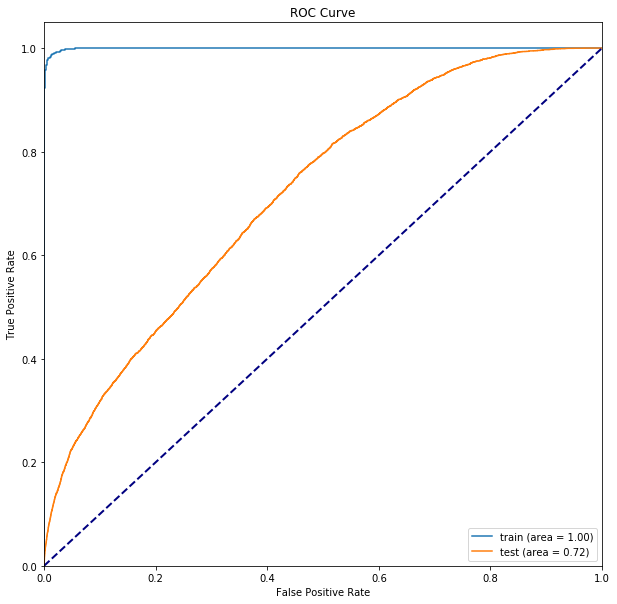

In [33]:
pred=test_model(model_path="QA/model1.h5")

# Overfitted solution 1 (Reduce epochs)
The model now is obviously overfitted, so we checked the validation loss, the first epo and 2nd have the lowest loss, so we train new model with lower epochs.

In [18]:
model_apply(model_path="QA/model2.h5", epo=2, val=0.2)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input1 (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
main_input2 (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
main_input3 (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 256)     10240000    main_input1[0][0]                
____________________________________________________________________________________________

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 210099 samples, validate on 52525 samples
Epoch 1/2
210099/210099 [==============================] - 5195s 25ms/step - loss: 0.2219 - accuracy: 0.9301 - val_loss: 0.2124 - val_accuracy: 0.9328
Epoch 2/2
210099/210099 [==============================] - 4149s 20ms/step - loss: 0.1946 - accuracy: 0.9344 - val_loss: 0.2158 - val_accuracy: 0.9321


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


<Figure size 432x288 with 0 Axes>

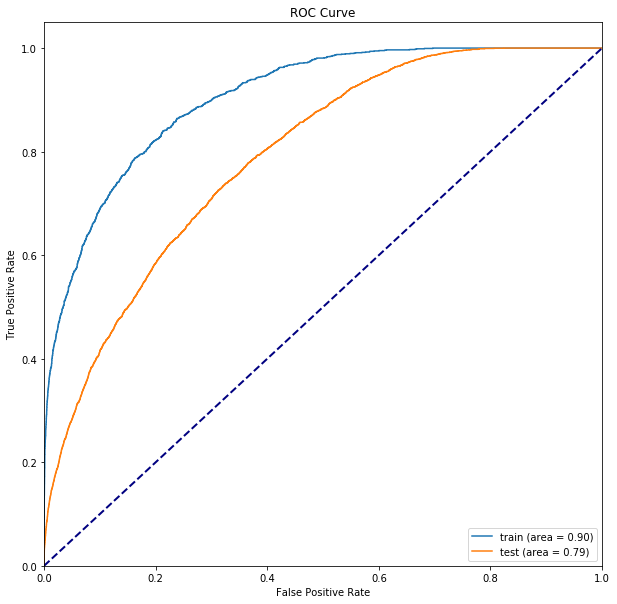

In [34]:
pred=test_model(model_path="QA/model2.h5")

# Overfit Solution 2 (Keep reducing)
The new model is still somewhat overfitted, we keep making epochs lower

In [8]:
model_apply(model_path="QA/model3.h5", epo=1, val=0.125)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input1 (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
main_input2 (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
main_input3 (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 256)     10240000    main_input1[0][0]                
____________________________________________________________________________________________

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 229796 samples, validate on 32828 samples
Epoch 1/1
229796/229796 [==============================] - 6482s 28ms/step - loss: 0.2182 - accuracy: 0.9306 - val_loss: 0.2045 - val_accuracy: 0.9333


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


<Figure size 432x288 with 0 Axes>

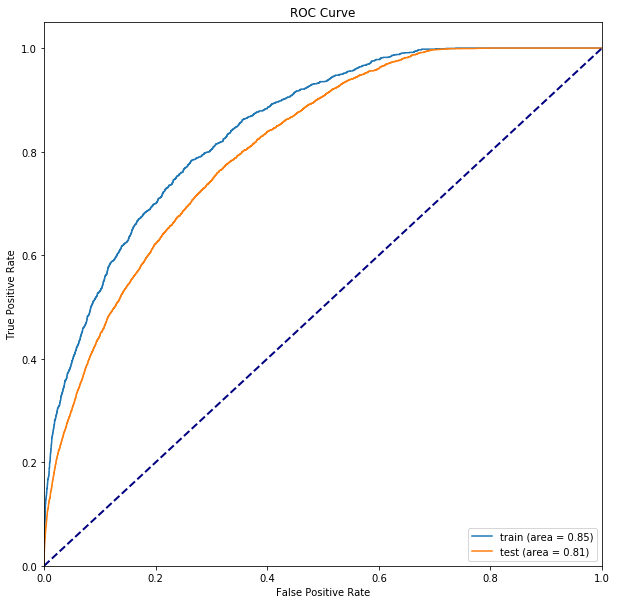

In [35]:
pred=test_model(model_path="QA/model3.h5")

# This will be my final model, with a Train AUC of 0.85 and test AUC of 0.81.